In [1]:
import gc
import numpy as np
import pandas as pd
import polars as pl
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
INPUT_DIR = "/kaggle/input/child-mind-institute-detect-sleep-states/"

## 1. Data Preparation

In [3]:
df_series = pl.read_parquet(INPUT_DIR + "train_series.parquet")
df_events = pl.read_csv(INPUT_DIR + "train_events.csv")
df_events = df_events.with_columns(
    pl.col("event").map_dict({"wakeup": 1.0, "onset": -1.0}, return_dtype=pl.Float32)
)

In [4]:
df_groupby = df_series.group_by("series_id", maintain_order=True)

dict_valid_ratio = dict()
list_feature_array = []
list_df_1min = []
for series_id, df in tqdm(df_groupby, total=df_series.get_column("series_id").n_unique()):
    df = (
        df.join(
            df_events.filter(pl.col("series_id") == series_id).select("timestamp", "event"),
            on="timestamp", how="left"
        ).with_columns(
            pl.col("timestamp").str.to_datetime(),
            pl.col("event").fill_null(0.0),
        ).with_columns(
            pl.col("timestamp").dt.date().cast(str).alias("date"),
            pl.col("timestamp").dt.time().cast(str).alias("time"),
        )
    ).to_pandas()
    
    df["timestamp"] = df["timestamp"].dt.tz_localize(None)
    dup_count = df.groupby(["anglez", "enmo", "time"])["step"].transform("count")
    df["valid_flag"] = (dup_count == 1).astype("float32")
    dict_valid_ratio[series_id] = df["valid_flag"].mean()
    
    list_feature_array_tmp = []
    df["log_anglez_std"] = np.log(df["anglez"].rolling(25, min_periods=1, center=True).std() + 1).astype("float32")
    df["log_enmo"] = np.log(df["enmo"] + 0.01).astype("float32")
    for feature in ["log_anglez_std", "log_enmo", "valid_flag"]:
        df_pivot = df.pivot(index=["series_id", "date"], columns="time", values=feature)
        feature_array = df_pivot.fillna(0).values
        feature_array_1day_bedore = df_pivot.shift(1).fillna(0).values
        feature_array_1day_after = df_pivot.shift(-1).fillna(0).values
        feature_array = np.concatenate([feature_array_1day_bedore[:, -180*12:], feature_array, feature_array_1day_after[:, :180*12]], axis=1)
        list_feature_array_tmp.append(feature_array)
    list_feature_array.append(np.stack(list_feature_array_tmp, axis=1))
    
    dict_agg = {"series_id": "first", "date": "first", "time": "first", "step": "mean", "event": "sum", "valid_flag": "max"}
    df_1min = df.resample("1min", on="timestamp").agg(dict_agg).reset_index()
    df_1min["step"] = df_1min["step"].astype("int32")
    values_event = df_1min["event"].values
    values_target = values_event.copy()
    for j in range(30):
        weight = np.exp(-j/2.8)
        values_target[:-(j+1)] += weight*values_event[(j+1):]  # shift backward
        if j > 0:
            values_target[j:] += weight*values_event[:-j]  # shift forward
    df_1min["target"] = values_target
    list_df_1min.append(df_1min)

del df_series, df_groupby

  0%|          | 0/277 [00:00<?, ?it/s]

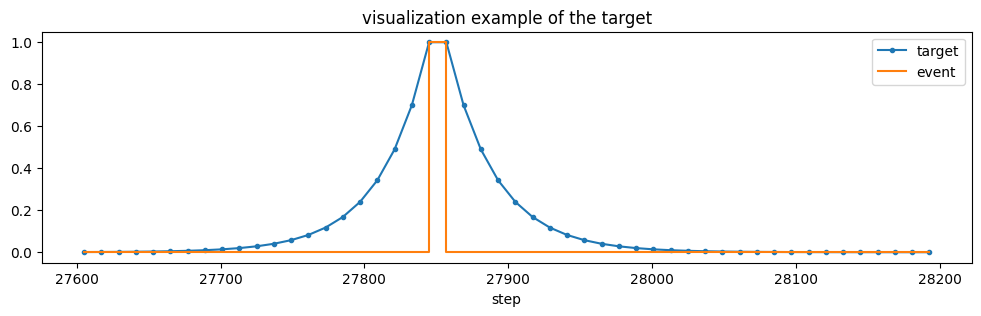

In [5]:
plt.figure(figsize=(12, 3))
plt.plot(df_1min.iloc[2300:2350]["step"], df_1min.iloc[2300:2350]["target"], marker=".", label="target")
plt.plot(df_1min.iloc[2300:2350]["step"], df_1min.iloc[2300:2350]["event"], drawstyle="steps-pre", label="event")
plt.title("visualization example of the target")
plt.xlabel("step")
plt.legend()
plt.show()

In [6]:
X = np.concatenate(list_feature_array)
del list_feature_array
X = (X - X.min(axis=(0, 2), keepdims=True)) / (X.max(axis=(0, 2), keepdims=True) - X.min(axis=(0, 2), keepdims=True))

X.shape

(7746, 3, 21600)

In [7]:
df_1min = pd.concat(list_df_1min)
del list_df_1min

df_1min

,timestamp,series_id,date,time,step,event,valid_flag,target
0,2018-08-14 19:30:00,038441c925bb,2018-08-14,19:30:00,5,0.0,1.0,0.0
1,2018-08-14 19:31:00,038441c925bb,2018-08-14,19:31:00,17,0.0,1.0,0.0
2,2018-08-14 19:32:00,038441c925bb,2018-08-14,19:32:00,29,0.0,1.0,0.0
3,2018-08-14 19:33:00,038441c925bb,2018-08-14,19:33:00,41,0.0,1.0,0.0
4,2018-08-14 19:34:00,038441c925bb,2018-08-14,19:34:00,53,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
49360,2017-09-08 04:10:00,fe90110788d2,2017-09-08,04:10:00,592325,0.0,1.0,0.0
49361,2017-09-08 04:11:00,fe90110788d2,2017-09-08,04:11:00,592337,0.0,1.0,0.0
49362,2017-09-08 04:12:00,fe90110788d2,2017-09-08,04:12:00,592349,0.0,1.0,0.0
49363,2017-09-08 04:13:00,fe90110788d2,2017-09-08,04:13:00,592361,0.0,1.0,0.0


In [8]:
gc.collect()

3773

In [9]:
df_y = df_1min.pivot(index=["series_id", "date"], columns="time", values="target").fillna(0)
df_mask = df_1min.pivot(index=["series_id", "date"], columns="time", values="valid_flag").fillna(0)
df_mask.to_parquet("df_mask.parquet")

df_y

/opt/conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


time                     00:00:00  00:01:00  00:02:00  00:03:00  00:04:00  \
series_id    date                                                           
038441c925bb 2018-08-14  0.000000  0.000000  0.000000  0.000000  0.000000   
             2018-08-15  0.000000  0.000000  0.000000  0.000000  0.000000   
             2018-08-16 -0.000271 -0.000189 -0.000133 -0.000093 -0.000065   
             2018-08-17  0.000000  0.000000  0.000000  0.000000  0.000000   
             2018-08-18  0.000000  0.000000  0.000000  0.000000  0.000000   
...                           ...       ...       ...       ...       ...   
fe90110788d2 2017-09-04  0.000000  0.000000  0.000000  0.000000  0.000000   
             2017-09-05  0.000000  0.000000  0.000000  0.000000  0.000000   
             2017-09-06  0.000000  0.000000  0.000000  0.000000  0.000000   
             2017-09-07  0.000000  0.000000  0.000000  0.000000  0.000000   
             2017-09-08  0.000000  0.000000  0.000000  0.000000  0.000000   

time                     00:05:00  00:06:00  00:07:00  00:08:00  00:09:00  \
series_id    date                                                           
038441c925bb 2018-08-14  0.000000  0.000000       0.0       0.0       0.0   
             2018-08-15  0.000000  0.000000       0.0       0.0       0.0   
             2018-08-16 -0.000045 -0.000032       0.0       0.0       0.0   
             2018-08-17  0.000000  0.000000       0.0       0.0       0.0   
             2018-08-18  0.000000  0.000000       0.0       0.0       0.0   
...                           ...       ...       ...       ...       ...   
fe90110788d2 2017-09-04  0.000000  0.000000       0.0       0.0       0.0   
             2017-09-05  0.000000  0.000000       0.0       0.0       0.0   
             2017-09-06  0.000000  0.000000       0.0       0.0       0.0   
             2017-09-07  0.000000  0.000000       0.0       0.0       0.0   
             2017-09-08  0.000000  0.000000       0.0       0.0       0.0   

time                     ...  23:50:00  23:51:00  23:52:00  23:53:00  \
series_id    date        ...                                           
038441c925bb 2018-08-14  ...   0.00000  0.000000  0.000000  0.000000   
             2018-08-15  ...  -0.00963 -0.006738 -0.004714 -0.003299   
             2018-08-16  ...   0.00000  0.000000  0.000000  0.000000   
             2018-08-17  ...   0.00000  0.000000  0.000000  0.000000   
             2018-08-18  ...   0.00000  0.000000  0.000000  0.000000   
...                      ...       ...       ...       ...       ...   
fe90110788d2 2017-09-04  ...   0.00000  0.000000  0.000000  0.000000   
             2017-09-05  ...   0.00000  0.000000  0.000000  0.000000   
             2017-09-06  ...   0.00000  0.000000  0.000000  0.000000   
             2017-09-07  ...   0.00000  0.000000  0.000000  0.000000   
             2017-09-08  ...   0.00000  0.000000  0.000000  0.000000   

time                     23:54:00  23:55:00  23:56:00  23:57:00  23:58:00  \
series_id    date                                                           
038441c925bb 2018-08-14  0.000000  0.000000   0.00000   0.00000  0.000000   
             2018-08-15 -0.002308 -0.001615  -0.00113  -0.00079 -0.000553   
             2018-08-16  0.000000  0.000000   0.00000   0.00000  0.000000   
             2018-08-17  0.000000  0.000000   0.00000   0.00000  0.000000   
             2018-08-18  0.000000  0.000000   0.00000   0.00000  0.000000   
...                           ...       ...       ...       ...       ...   
fe90110788d2 2017-09-04  0.000000  0.000000   0.00000   0.00000  0.000000   
             2017-09-05  0.000000  0.000000   0.00000   0.00000  0.000000   
             2017-09-06  0.000000  0.000000   0.00000   0.00000  0.000000   
             2017-09-07  0.000000  0.000000   0.00000   0.00000  0.000000   
             2017-09-08  0.000000  0.000000   0.00000   0.00000  0.000000   

time                     23:59:00  
series_id    date    

## 2. Regression Model (1D-CNN UNet)

The architecture of my NN model is based on the following notebook written by [@K_mat](https://www.kaggle.com/kmat2019) in the other competition.  
https://www.kaggle.com/code/kmat2019/u-net-1d-cnn-with-keras

Thanks and congrats on 2nd Place!

### 2.1. definition of classes and functions

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, Y, flag):
        self.X = torch.FloatTensor(X)
        if Y is not None:
            self.Y = torch.FloatTensor(Y)
        self.flag = torch.FloatTensor(flag)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if "Y" in dir(self):
            return (self.X[idx], self.Y[idx], self.flag[idx])
        else:
            return (self.X[idx], torch.Tensor(), self.flag[idx])

In [11]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super().__init__()
        
        if stride == 1:
            padding = "same"
        else:
            padding = (kernel_size - stride) // 2
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        x_out = self.layers(x)
        return x_out


class SEBlock(nn.Module):
    def __init__(self, n_channels, se_ratio):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.AdaptiveAvgPool1d(output_size=1),  #  Global Average Pooling
            nn.Conv1d(n_channels, n_channels//se_ratio, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(n_channels//se_ratio, n_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_out = torch.mul(x, self.layers(x))
        return x_out


class ResBlock(nn.Module):
    def __init__(self, n_channels, kernel_size, se_ratio):
        super().__init__()
        
        self.layers = nn.Sequential(
            ConvBNReLU(n_channels, n_channels, kernel_size, stride=1),
            ConvBNReLU(n_channels, n_channels, kernel_size, stride=1),
            SEBlock(n_channels, se_ratio)
        )
    
    def forward(self, x):
        x_re = self.layers(x)
        x_out = x + x_re
        return x_out
    

class UNet1d(nn.Module):
    def __init__(self, input_channels, initial_channels, initial_kernel_size,
                 down_channels, down_kernel_size, down_stride, res_depth, res_kernel_size, se_ratio, out_kernel_size):
        super().__init__()
        self.down_kernel_size = down_kernel_size
        self.down_stride = down_stride
        
        self.initial_layers = ConvBNReLU(input_channels, initial_channels, initial_kernel_size, stride=1, groups=input_channels)
        
        self.down_layers = nn.ModuleList()
        for i in range(len(down_channels)):
            if i == 0:
                in_channels = initial_channels
            else:
                in_channels = down_channels[i-1] + input_channels
            out_channels = down_channels[i]
            kernel_size = down_kernel_size[i]
            stride = down_stride[i]
            
            block = []
            block.append(ConvBNReLU(in_channels, out_channels, kernel_size, stride))
            for j in range(res_depth):
                block.append(ResBlock(out_channels, res_kernel_size, se_ratio))
            self.down_layers.append(nn.Sequential(*block))
        
        self.up_layers = nn.ModuleList()
        for i in range(len(down_channels)-1, 0, -1):
            in_channels = out_channels + down_channels[i]
            out_channels = down_channels[i]
            kernel_size = down_kernel_size[i]
            self.up_layers.append(ConvBNReLU(in_channels, out_channels, kernel_size, stride=1))
        
        self.out_layers = nn.Conv1d(down_channels[1], 1, out_kernel_size, padding="same")
    
    def forward(self, x):
        outs = []
        x_avg = x
        x = self.initial_layers(x)
        
        for i in range(len(self.down_layers)):
            x_out = self.down_layers[i](x)
            if i == len(self.down_layers) - 1:
                x = x_out
            else:
                outs.append(x_out)
                kernel_size = self.down_kernel_size[i]
                stride = self.down_stride[i]
                padding = (kernel_size - stride) // 2
                x_avg = F.avg_pool1d(x_avg, kernel_size, stride, padding)
                x = torch.cat([x_out, x_avg], dim=1)
        
        for i in range(len(self.up_layers)):
            scale_factor = self.down_stride[-i-1]
            x = F.interpolate(x, scale_factor=scale_factor, mode="linear")
            x = torch.cat([x, outs[-i-1]], dim=1)
            x = self.up_layers[i](x)
        
        x_out = self.out_layers(x)
        x_out = x_out[:, 0, 180:-180]
        
        return x_out

In [12]:
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    
    for batch in data_loader:
        X = batch[0].to(device)
        Y = batch[1].to(device)
        mask = batch[2].to(device)
        
        preds = model(X) * mask
        loss = criterion(preds, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def evaluate(model, data_loader, criterion, device):
    model.eval()
    
    n = 0
    total_loss = 0.0
    for batch in data_loader:
        X = batch[0].to(device)
        Y = batch[1].to(device)
        mask = batch[2].to(device)
        
        with torch.no_grad():
            preds = model(X) * mask
        
        loss = criterion(preds, Y)
        total_loss += loss.item() * X.shape[0]
        n += X.shape[0]
    
    avg_loss = total_loss / n
    
    return avg_loss


def predict(model, data_loader, device):
    model.eval()
    
    preds_all = []
    for batch in data_loader:
        X = batch[0].to(device)
        mask = batch[2].to(device)
        
        with torch.no_grad():
            preds = model(X) * mask
        preds = preds.cpu().numpy()
        preds_all.append(preds)
    
    preds_all = np.concatenate(preds_all)
        
    return preds_all

### 2.2. train model

In [13]:
n_splits = 10
n_epochs = 15
batch_size = 16
    
Y = df_y.values
mask = df_mask.values
groups = df_y.index.get_level_values("series_id").tolist()

preds_valid = np.zeros_like(Y)
gkf = GroupKFold(n_splits=n_splits)
for fold, (idx_train, idx_valid) in enumerate(gkf.split(X, Y, groups=groups)):   
    print(f"fold: {fold}")
    X_train = X[idx_train]
    Y_train = Y[idx_train]
    mask_train = mask[idx_train]

    X_valid = X[idx_valid]
    Y_valid = Y[idx_valid]
    mask_valid = mask[idx_valid]

    # dataset
    ds_train = MyDataset(X_train, Y_train, mask_train)
    ds_valid = MyDataset(X_valid, Y_valid, mask_valid)

    # dataloader
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, 
                          num_workers=0, pin_memory=True, drop_last=True)
    dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, 
                          num_workers=0, pin_memory=True, drop_last=False)

    # build model
    torch.manual_seed(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = UNet1d(
        input_channels=X.shape[1],
        initial_channels=72,
        initial_kernel_size=15,
        down_channels=(72, 72, 72),
        down_kernel_size=(12, 15, 15),
        down_stride=(12, 9, 5),  # first element must be 12
        res_depth=3,
        res_kernel_size=15,
        se_ratio=4,
        out_kernel_size=21,
    )
    if fold == 0:
        print(summary(
            model=model,
            input_size=(batch_size, X.shape[1], X.shape[2]),
            col_names=["input_size", "output_size", "num_params"],
            col_width=20
        ))
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.MSELoss()

    best_loss = np.inf
    for epoch in range(n_epochs):
        train(model, dl_train, optimizer, criterion, device)
        loss = evaluate(model, dl_valid, criterion, device)
        scheduler.step()
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), f"model_{fold}.pth")
            print(f"epoch: {epoch}\tvalid-loss: {loss}\tbest!")
        else:
            print(f"epoch: {epoch}\tvalid-loss: {loss}")

    with torch.no_grad():
        model.load_state_dict(torch.load(f"model_{fold}.pth"))
        preds_valid[idx_valid] = predict(model, dl_valid, device)
    print(f"best_loss: {best_loss}")
    print()

rmse = mean_squared_error(Y, preds_valid, squared=False)
print(f"RMSE: {rmse:.5f}")

fold: 0
Layer (type:depth-idx)                                       Input Shape          Output Shape         Param #
UNet1d                                                       [16, 3, 21600]       [16, 1440]           --
├─ConvBNReLU: 1-1                                            [16, 3, 21600]       [16, 72, 21600]      --
│    └─Sequential: 2-1                                       [16, 3, 21600]       [16, 72, 21600]      --
│    │    └─Conv1d: 3-1                                      [16, 3, 21600]       [16, 72, 21600]      1,152
│    │    └─BatchNorm1d: 3-2                                 [16, 72, 21600]      [16, 72, 21600]      144
│    │    └─ReLU: 3-3                                        [16, 72, 21600]      [16, 72, 21600]      --
├─ModuleList: 1-2                                            --                   --                   --
│    └─Sequential: 2-2                                       [16, 72, 21600]      [16, 72, 1800]       --
│    │    └─ConvBNReLU: 3-4  

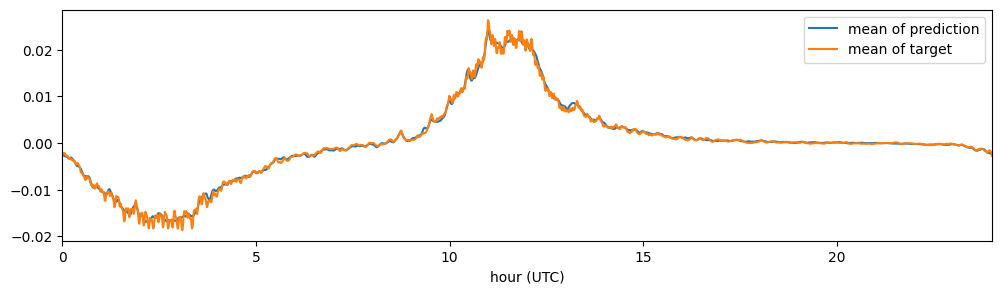

In [14]:
plt.figure(figsize=(12, 3))
plt.plot(np.linspace(0, 24, 60*24), preds_valid.mean(axis=0), label="mean of prediction")
plt.plot(np.linspace(0, 24, 60*24), df_y.mean().values, label="mean of target")
plt.xlim(0, 24)
plt.xlabel("hour (UTC)")
plt.legend()
plt.show()

In [15]:
df_pred = pd.DataFrame(preds_valid, index=df_y.index, columns=df_y.columns)
df_pred = df_pred.stack().reset_index(name="score")
df_pred = pd.merge(
    df_1min[["series_id", "date", "time", "step", "event"]],
    df_pred,
    on=["series_id", "date", "time"],
    how="inner"
)
df_pred

,series_id,date,time,step,event,score
0,038441c925bb,2018-08-14,19:30:00,5,0.0,0.007822
1,038441c925bb,2018-08-14,19:31:00,17,0.0,-0.015719
2,038441c925bb,2018-08-14,19:32:00,29,0.0,-0.006000
3,038441c925bb,2018-08-14,19:33:00,41,0.0,-0.014575
4,038441c925bb,2018-08-14,19:34:00,53,0.0,-0.011227
...,...,...,...,...,...,...
10662190,fe90110788d2,2017-09-08,04:10:00,592325,0.0,0.002876
10662191,fe90110788d2,2017-09-08,04:11:00,592337,0.0,0.002501
10662192,fe90110788d2,2017-09-08,04:12:00,592349,0.0,0.003046
10662193,fe90110788d2,2017-09-08,04:13:00,592361,0.0,0.006580


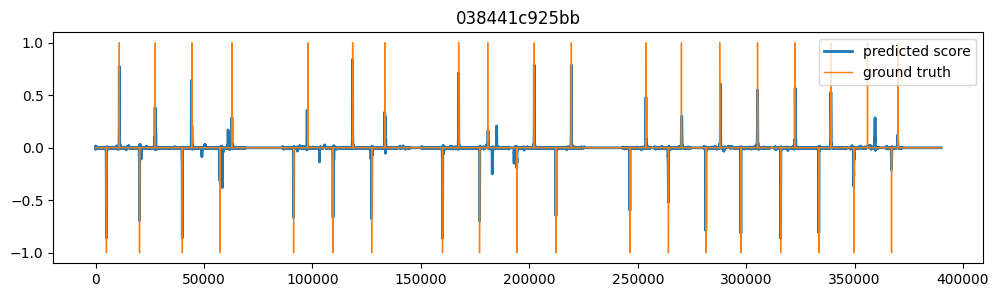

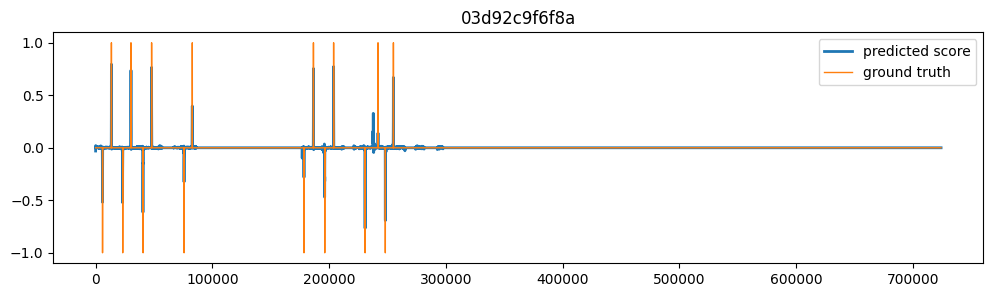

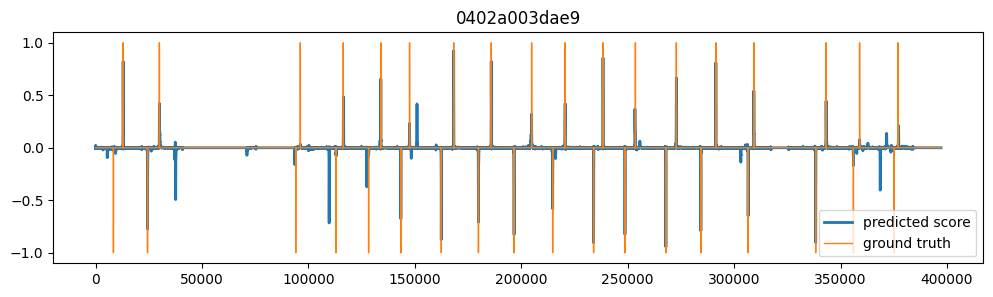

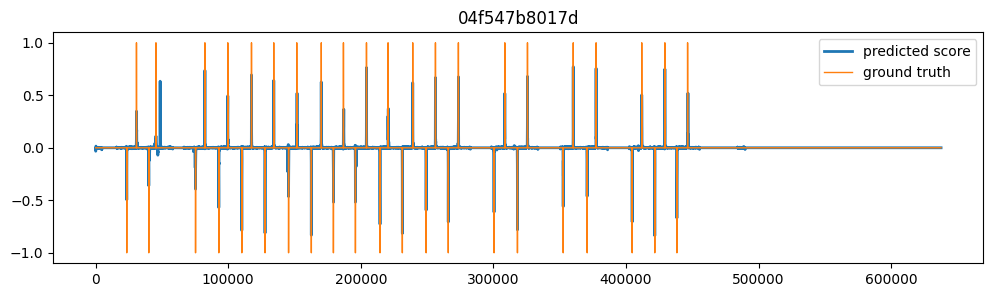

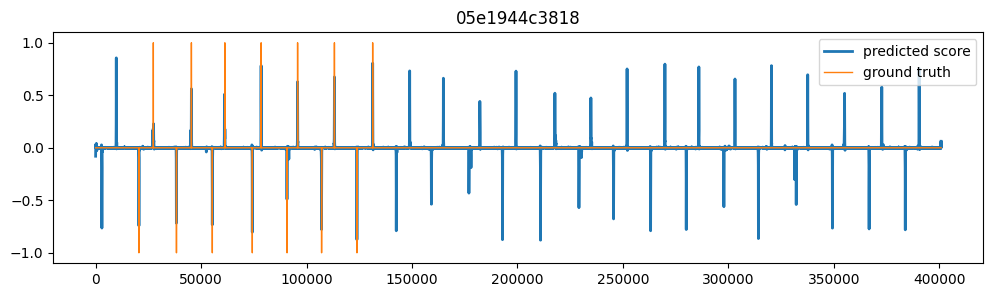

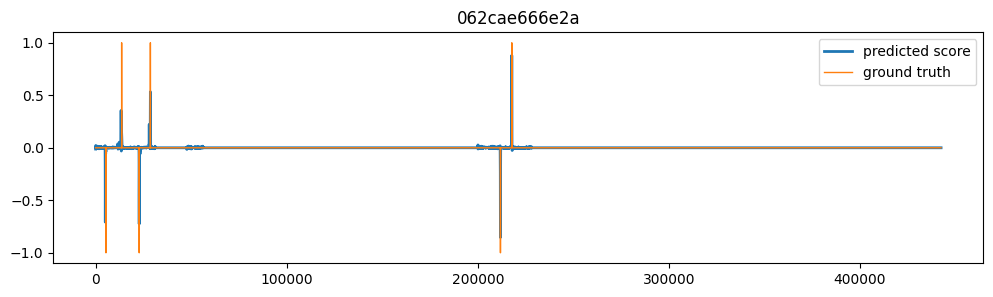

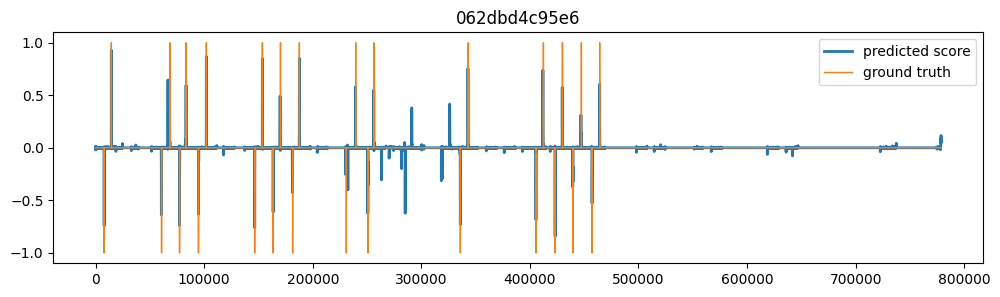

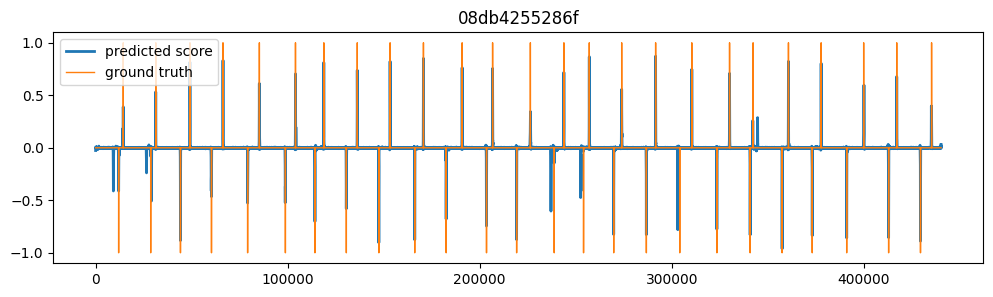

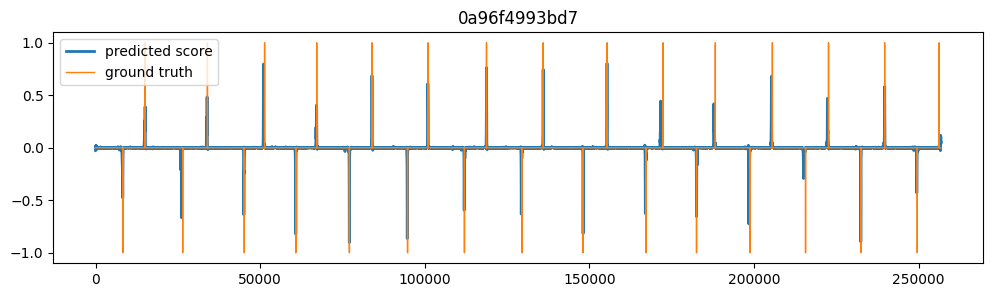

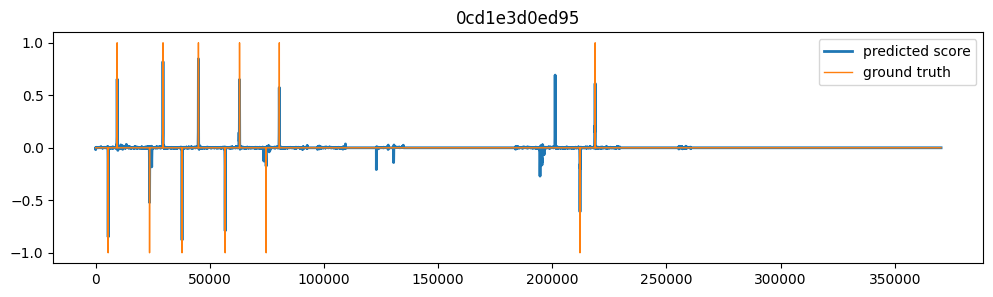

In [16]:
for i, (series_id, df) in enumerate(df_pred.groupby("series_id")):
    if i == 10:
        break
    plt.figure(figsize=(12, 3))
    plt.plot(df["step"], df["score"], linewidth=2, label="predicted score")
    plt.plot(df["step"], df["event"], linewidth=1, label="ground truth")
    plt.legend()
    plt.title(series_id)
    plt.show()
    plt.close()

## 3. Make Submission

### 3.1. without post-prosessing (only peak detection)

In [17]:
list_df = []
for series_id, df in tqdm(df_pred.groupby("series_id")):
    for event in ["onset", "wakeup"]:
        values_step = df["step"].values
        if event == "onset":
            values_score = -df["score"].values
        else:
            values_score = df["score"].values

        peak_idx = find_peaks(values_score, height=0.0, distance=8)[0]
        df_peak = pd.DataFrame(values_step[peak_idx], columns=["step"])
        df_peak["series_id"] = series_id
        df_peak["event"] = event
        df_peak["score"] = values_score[peak_idx]
        list_df.append(df_peak)

df_sub = pd.concat(list_df)
df_sub = df_sub.sort_values("score", ascending=False).groupby("event").head(100000)  # avoid Submission Scoring Error
df_sub = df_sub.sort_values(["series_id", "step"]).reset_index(drop=True)
df_sub = df_sub[["series_id", "step", "event", "score"]].reset_index(names="row_id")
df_sub.to_csv("df_sub_without_pp.csv", index=False)
df_sub

  0%|          | 0/277 [00:00<?, ?it/s]

,row_id,series_id,step,event,score
0,0,038441c925bb,17,onset,0.015719
1,1,038441c925bb,113,wakeup,0.017130
2,2,038441c925bb,485,wakeup,0.006627
3,3,038441c925bb,785,wakeup,0.005720
4,4,038441c925bb,1661,onset,0.005499
...,...,...,...,...,...
199995,199995,fe90110788d2,590369,wakeup,0.005254
199996,199996,fe90110788d2,591125,wakeup,0.005326
199997,199997,fe90110788d2,591773,onset,0.006726
199998,199998,fe90110788d2,592217,onset,0.008989


### 3.2 with post-processing

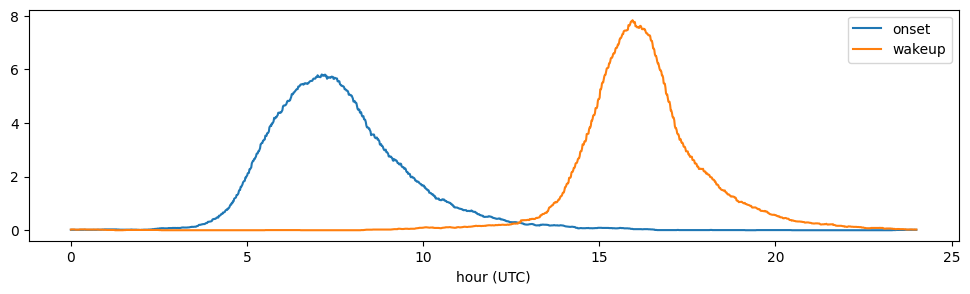

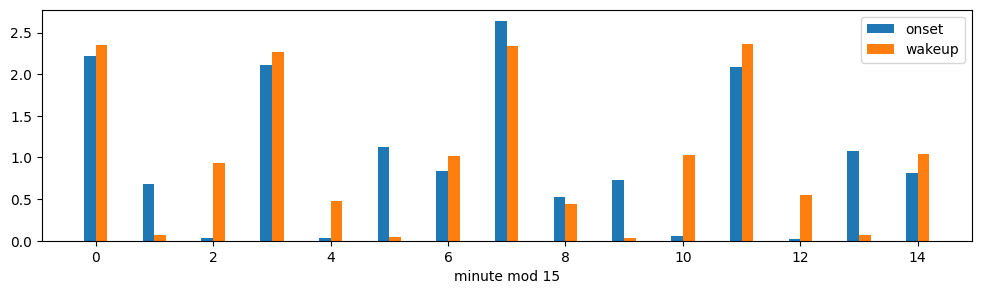

In [18]:
df_events = pd.read_csv(INPUT_DIR + "train_events.csv").dropna()
df_events["timestamp"] = pd.to_datetime(df_events["timestamp"], utc=True).dt.tz_localize(None)
df_events["time"] = df_events["timestamp"].dt.time.astype(str)
df_events["minute_mod15"] = df_events["timestamp"].dt.minute % 15

df_agg = df_events.groupby(["time", "event"], as_index=False).size()
df_agg["rate"] = df_agg["size"] / df_agg.groupby("event")["size"].transform("sum") * (60*24)
df_time = df_agg.pivot(index="time", columns="event", values="rate").fillna(0).reset_index()
df_time = df_time.merge(df_pred[["time"]].drop_duplicates(), how="right").fillna(0)
df_time = pd.concat([df_time]*3, ignore_index=True)
df_time["onset"] = df_time["onset"].rolling(60, center=True).mean()
df_time["wakeup"] = df_time["wakeup"].rolling(60, center=True).mean()
df_time = df_time.iloc[60*24:-60*24].reset_index(drop=True)

df_agg = df_events.groupby(["minute_mod15", "event"], as_index=False).size()
df_agg["rate"] = df_agg["size"] / df_agg.groupby("event")["size"].transform("sum") * 15
df_minute = df_agg.pivot(index="minute_mod15", columns="event", values="rate").reset_index()

plt.figure(figsize=(12, 3))
plt.plot(np.linspace(0, 24, 60*24), df_time["onset"], label="onset")
plt.plot(np.linspace(0, 24, 60*24), df_time["wakeup"], label="wakeup")
plt.xlabel("hour (UTC)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.bar(np.linspace(0, 14, 15)-0.1, df_minute["onset"], width=0.2, label="onset")
plt.bar(np.linspace(0, 14, 15)+0.1, df_minute["wakeup"], width=0.2, label="wakeup")
plt.xlabel("minute mod 15")
plt.legend()
plt.show()

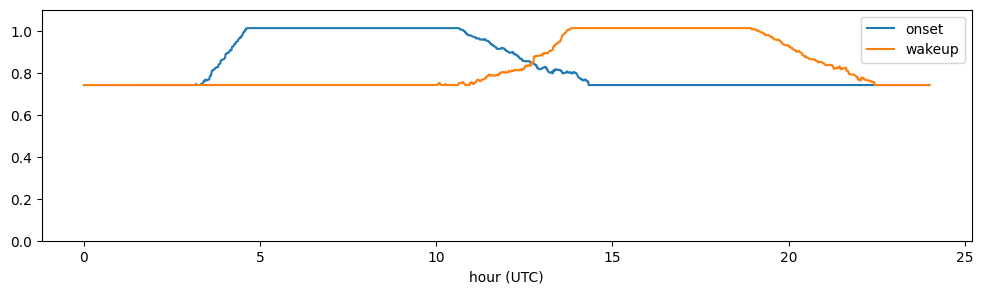

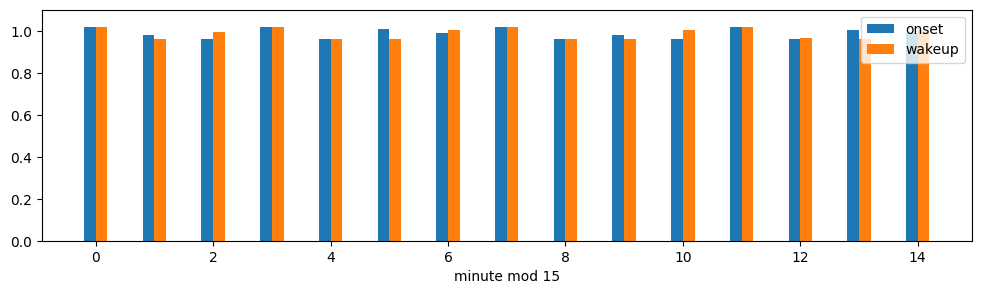

In [19]:
df_time[["onset", "wakeup"]] = df_time[["onset", "wakeup"]].clip(0.1, 1.1) ** 0.13
df_minute[["onset", "wakeup"]] = df_minute[["onset", "wakeup"]].clip(0.5, 1.3) ** 0.06

plt.figure(figsize=(12, 3))
plt.plot(np.linspace(0, 24, 60*24), df_time["onset"], label="onset")
plt.plot(np.linspace(0, 24, 60*24), df_time["wakeup"], label="wakeup")
plt.ylim(0, 1.1)
plt.xlabel("hour (UTC)")
plt.legend()
plt.show()

plt.figure(figsize=(12, 3))
plt.bar(np.linspace(0, 14, 15)-0.1, df_minute["onset"], width=0.2, label="onset")
plt.bar(np.linspace(0, 14, 15)+0.1, df_minute["wakeup"], width=0.2, label="wakeup")
plt.ylim(0, 1.1)
plt.xlabel("minute mod 15")
plt.legend()
plt.show()

In [20]:
df_pred["minute_mod15"] = df_pred["time"].str[3:5].astype(int) % 15

In [21]:
list_df = []
for series_id, df in tqdm(df_pred.groupby("series_id")):
    df = df.merge(df_time, how="left", on="time")
    df = df.merge(df_minute, how="left", on="minute_mod15")
    
    df_tmp = df.copy()
    df_tmp["score"] = df_tmp["score"].replace(0.0, np.nan)
    df_tmp = df_tmp.groupby("time")["score"].mean()
    df_tmp = pd.concat([df_tmp]*3).rolling(90, center=True, min_periods=1).mean()
    df_tmp = df_tmp.iloc[60*24:-60*24].reset_index().rename({"score": "score_mean"}, axis=1)
    df = df.merge(df_tmp, on="time", how="left")
    
    df["score"] = 0.9*df["score"] + 0.1*df["score_mean"]
    df["score"] *= np.where(df["score"]>0, df["wakeup_x"], df["onset_x"])
    df["score"] *= np.where(df["score"]>0, df["wakeup_y"], df["onset_y"])
    valid_ratio = dict_valid_ratio[series_id]
    
    for event in ["onset", "wakeup"]:
        values_step = df["step"].values
        if event == "onset":
            values_score = -df["score"].values
        else:
            values_score = df["score"].values
        
        # measure peaks
        peak_idx = find_peaks(values_score, height=0.04, distance=60*16)[0]  # at least 16 hours interval
        df_measure_peak = pd.DataFrame(values_step[peak_idx], columns=["step"])
        df_measure_peak["series_id"] = series_id
        df_measure_peak["event"] = event
        df_measure_peak["score"] = values_score[peak_idx] * 4 * valid_ratio**0.15
        
        # minor peaks
        peak_idx = find_peaks(values_score, height=0.0, distance=6)[0]
        df_minor_peak = pd.DataFrame(values_step[peak_idx], columns=["step"])
        df_minor_peak["series_id"] = series_id
        df_minor_peak["event"] = event
        df_minor_peak["score"] = values_score[peak_idx]
        
        df_peak = pd.concat([df_measure_peak, df_minor_peak]).drop_duplicates(subset=["step"])
        list_df.append(df_peak)
        
df_sub = pd.concat(list_df)
df_sub = df_sub.sort_values("score", ascending=False).groupby("event").head(100000)  # avoid Submission Scoring Error
df_sub = df_sub.sort_values(["series_id", "step"]).reset_index(drop=True)
df_sub = df_sub[["series_id", "step", "event", "score"]].reset_index(names="row_id")
df_sub.to_csv("df_sub_with_pp.csv", index=False)
df_sub

  0%|          | 0/277 [00:00<?, ?it/s]

,row_id,series_id,step,event,score
0,0,038441c925bb,17,onset,0.010357
1,1,038441c925bb,113,wakeup,0.010877
2,2,038441c925bb,2513,onset,0.005295
3,3,038441c925bb,2849,onset,0.005533
4,4,038441c925bb,2945,onset,0.005239
...,...,...,...,...,...
199995,199995,fe90110788d2,591437,onset,0.005623
199996,199996,fe90110788d2,591545,onset,0.006400
199997,199997,fe90110788d2,591629,onset,0.005675
199998,199998,fe90110788d2,591773,onset,0.009051


## 4. Scoring

The fast evaluation functions implemented by [@213tubo](https://www.kaggle.com/tubotubo) were very beneficial in my experiments and saved me a lot of time. Thanks\!  
https://github.com/tubo213/kaggle-child-mind-institute-detect-sleep-states/blob/main/src/utils/metrics.py

In [22]:
from bisect import bisect_left
from typing import Dict, List, Tuple


class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = "series_id"
time_column_name = "step"
event_column_name = "event"
score_column_name = "score"
use_scoring_intervals = False
tolerances = {
    "onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
}


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]],
    series_id_column_name: str,
    time_column_name: str,
    event_column_name: str,
    score_column_name: str,
    use_scoring_intervals: bool = False,
    verbose: bool = True,
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference(
        {"start", "end"}
    ), (
        f"Solution column {event_column_name} must contain the same events "
        "as defined in tolerances."
    )
    assert pd.api.types.is_numeric_dtype(
        solution[time_column_name]
    ), f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(
                f"Submission must have column '{column_name}'."
            )

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()["series_id_column_name"] = series_id_column_name
    globals()["time_column_name"] = time_column_name
    globals()["event_column_name"] = event_column_name
    globals()["score_column_name"] = score_column_name
    globals()["use_scoring_intervals"] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances, verbose=verbose)


def find_nearest(xs: np.ndarray, value):
    """
    Find the index of the closest value to x in the array xs.
    """
    idx = np.searchsorted(xs, value, side="left")
    best_idx = None
    best_error = float("inf")
    best_diff = float("inf")

    range_min = max(0, idx - 1)
    range_max = min(len(xs), idx + 2)
    for check_idx in range(
        range_min, range_max
    ):  # Check the exact, one before, and one after
        error = abs(xs[check_idx] - value)
        if error < best_error:
            best_error = error
            best_idx = check_idx
            best_diff = xs[check_idx] - value

    return best_idx, best_error, best_diff


def find_nearest_time_idx(sorted_gt_times, det_time, excluded_indices: set):
    """
    search index of gt_times closest to det_time.

    assumes gt_times is sorted in ascending order.
    """
    # e.g. if gt_times = [0, 1, 2, 3, 4, 5] and det_time = 2.5, then idx = 3
    sorted_gt_times = np.asarray(sorted_gt_times)
    available_indices = np.asarray(
        sorted(set(range(len(sorted_gt_times))) - excluded_indices), dtype=int
    )
    sorted_gt_times = sorted_gt_times[available_indices]
    idx, error, diff = find_nearest(sorted_gt_times, det_time)
    best_idx = available_indices[idx] if idx is not None else None

    return best_idx, error, diff


def match_detections(
    tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    detections_sorted = detections.sort_values(
        score_column_name, ascending=False
    ).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    diffs = np.full_like(
        detections_sorted[event_column_name], float("inf"), dtype=float
    )
    ground_truths_times = ground_truths.sort_values(time_column_name)[
        time_column_name
    ].to_list()
    matched_gt_indices: set[int] = set()

    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        det_time = getattr(det, time_column_name)

        best_idx, best_error, best_diff = find_nearest_time_idx(
            ground_truths_times, det_time, matched_gt_indices
        )

        if (best_idx is not None) and (best_error < tolerance):
            is_matched[i] = True
            diffs[i] = best_diff
            matched_gt_indices.add(best_idx)

    detections_sorted["matched"] = is_matched
    detections_sorted["diff"] = diffs
    return detections_sorted


def precision_recall_curve(
    matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind="stable")[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = (
        tps / p
    )  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]] = tolerances,
    progress_bar: bool = True,
    verbose: bool = True,
) -> Tuple[float, pd.DataFrame, pd.DataFrame]:
    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        raise NotImplementedError("Scoring intervals not implemented.")

    # Extract ground-truth events.
    ground_truths = solution.query("event not in ['start', 'end']").reset_index(
        drop=True
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched=False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        raise NotImplementedError("Scoring intervals not implemented.")
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [
            (ev, tol, vid)
            for ev in tolerances.keys()
            for tol in tolerances[ev]
            for vid in ground_truths[series_id_column_name].unique()
        ],
        columns=[event_column_name, "tolerance", series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = aggregation_keys.merge(
        detections_filtered, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])
    ground_truths_grouped = aggregation_keys.merge(
        ground_truths, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])

    # Match detections to ground truth events by evaluation group
    pbars = aggregation_keys.itertuples(index=False)
    if progress_bar:
        pbars = tqdm(pbars, total=len(aggregation_keys), desc="Matching detections")
    detections_matched = []
    for key in pbars:
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets["tolerance"].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched.query("event in @event_classes")
        .groupby([event_column_name, "tolerance"])
        .apply(
            lambda group: average_precision_score(
                group["matched"].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
        .reset_index()
        .pivot(index="tolerance", columns="event", values=0)
    )
    if verbose:
        display(ap_table)
    # Average over tolerances, then over event classes
    mean_ap = ap_table.mean().mean()

    return mean_ap, ap_table, detections_matched

In [23]:
df_sub = pd.read_csv("df_sub_without_pp.csv")
score_all, df_score, df_result = score(
    solution=df_events,
    submission=df_sub,
    tolerances=tolerances,
    series_id_column_name=series_id_column_name,
    time_column_name=time_column_name,
    event_column_name=event_column_name,
    score_column_name=score_column_name
)
print(score_all)

Matching detections:   0%|          | 0/5380 [00:00<?, ?it/s]

event,onset,wakeup
tolerance,,
12,0.406732,0.408050
36,0.706291,0.715397
60,0.784056,0.803019
90,0.836292,0.840025
120,0.857057,0.859365
150,0.867274,0.869982
180,0.877377,0.878847
240,0.887540,0.892905
300,0.892829,0.905801


0.8050710345253291


In [24]:
df_sub = pd.read_csv("df_sub_with_pp.csv")
score_all, df_score, df_result = score(
    solution=df_events,
    submission=df_sub,
    tolerances=tolerances,
    series_id_column_name=series_id_column_name,
    time_column_name=time_column_name,
    event_column_name=event_column_name,
    score_column_name=score_column_name
)
print(score_all)

Matching detections:   0%|          | 0/5380 [00:00<?, ?it/s]

event,onset,wakeup
tolerance,,
12,0.437678,0.463164
36,0.712054,0.710010
60,0.792607,0.811038
90,0.836243,0.843234
120,0.853433,0.860210
150,0.865081,0.872385
180,0.877901,0.881279
240,0.888304,0.896029
300,0.893908,0.908854


0.8110506245796845
